In [244]:
import os
import glob
import LatLon 
import numpy as np
import pandas as pd

# plot
%matplotlib inline
import pylab
import seaborn as sns
sns.set_style("whitegrid")
from pysurvey.plot import setup, legend, icolorbar, density

# date
from dateutil import parser
from matplotlib.dates import date2num

# database
import dataset
from sqlalchemy import create_engine
from sqlalchemy_utils import database_exists, create_database

# Load Data

  * Original decision was to store the data straight to disk as flat text files.
  * This lower the load on the pi, so lets grab the right columns, and build up a large ~200MB dataframe

In [188]:
filenamepattern = '/Users/ajmendez/flight/locations_*.log'
data = None
for i, filename in enumerate(glob.glob(filenamepattern)):
    tmp = pd.read_csv(filename, skiprows=1, usecols=[4,6,7,11,14,15], 
                     names='flight date time alt lat lon'.split())
    if data is None:
        data = tmp
#         break
    else:
        data =  pd.concat([data, tmp], ignore_index=True)

In [189]:
pd.set_option('display.max_rows', 5)
data

,flight,date,time,alt,lat,lon
0,AA9249,2016/01/15,02:24:21.604,8625,39.12570,-77.53583
1,AA9249,2016/01/15,02:24:22.969,8675,39.12730,-77.53491
...,...,...,...,...,...,...
2208973,A9A97F,2016/01/31,12:42:23.321,36000,40.36322,-76.64349
2208974,A9A97F,2016/01/31,12:42:24.898,36000,40.36279,-76.64712


# Create Tags (data features)

  * flightnum -- unique flight number
  * datenum -- the number of days since the start
  * distance -- distance away from antenna
  * heading -- angle from north for plane
  * x,y -- rotated coordinates for easy plots

In [190]:
# Check multidimensional issues
for i in data.index:
    assert len(data['lon'][i].shape) == 0, IndexError('Multidimension issue -- check files')

In [372]:
tmp = {flight:i for i,flight in enumerate(sorted(np.unique(data['flight'])))}
data['flightnum'] = data['flight'].map(tmp)

In [191]:
# datenum is the number of days since the 
tmp = (data['date']+' '+data['time']).apply(parser.parse)
data['datenum'] = tmp.apply(date2num)
data['datenum'] -= data['datenum'].min()

In [306]:
data['hour'] = (data['datenum'] % 1)*24
data['weekday'] = (data['datenum'] % 7).apply(np.int)
data['normtime'] = data['datenum']/data['datenum'].max()

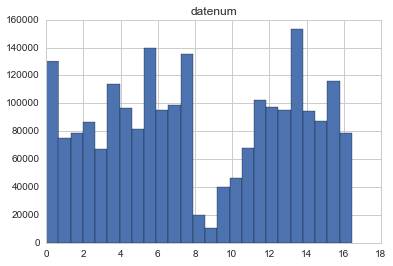

In [196]:
_ = data.hist('datenum', bins=25)
# You can clearly see the effects of snow on flights in the north and east of Baltimore City

In [233]:
# initial heading, distance to each point from the antenna
ant = LatLon.LatLon(39.331832, -76.623450)
def get_heading_distance(tmp):
    heading, distance = np.zeros( (2, tmp.shape[0]) )
    for i in tmp.index:
        try:
            loc = LatLon.LatLon(tmp['lat'][i],tmp['lon'][i])
        except Exception as e:
            print i, tmp['lat'][i],tmp['lon'][i]
            raise
        heading[i] = ant.heading_initial(loc)
        distance[i] = ant.distance(loc)
    return heading, distance

data['heading_deg'], data['distance'] = get_heading_distance(data[['lat', 'lon']])
data['heading']  = np.deg2rad(data['heading_deg'])
# Keep degree heading for filtering below
data.loc[data['heading_deg']<0, 'heading_deg'] += 360

In [263]:
def setup_polarplot(subplt=111):
    ax = pylab.subplot(subplt, projection='polar')
    ax.set_theta_direction(-1)
    ax.set_theta_zero_location('N')
    ax.set_xlabel('heading')
    ax.set_ylabel('direction [km]')
    return ax


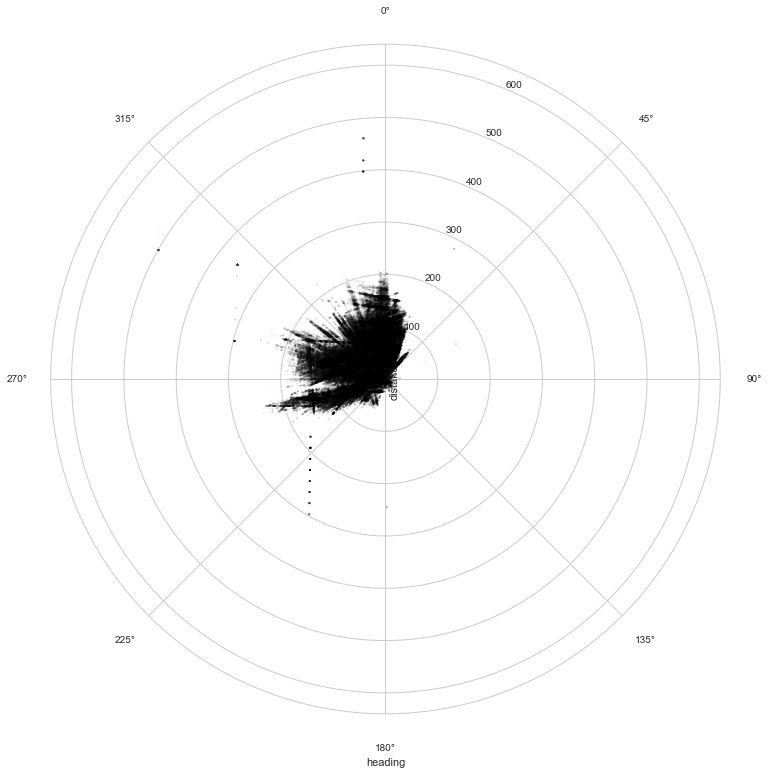

In [201]:
tmp =  data[data['distance'] < 1000] # inital cleaning
pylab.figure(figsize=(12,12))
tmp.plot('heading', 'distance', 'scatter', 
         c=tmp['datenum'], ax=setup_polarplot(),
         s=4, edgecolor='none', alpha=0.2)

In [350]:
from mpl_toolkits.axes_grid.axislines import SubplotZero
from matplotlib.ticker import MultipleLocator, FuncFormatter

def setup_polar(subplt=111):
    fig = pylab.gcf()
    ax = SubplotZero(fig, subplt)
    fig.add_subplot(ax)
    for d in ax.axis:
        ax.axis[d].set_visible(d.endswith("zero"))
    tick_format = lambda x, i: '' if x == 0.0 else '%.0f' % x
    for a in [ax.xaxis, ax.yaxis]:
        a.set_minor_locator(MultipleLocator(10))
        a.set_major_formatter(FuncFormatter(tick_format))
    for r in range(0,200,25):
        lab = '{:0.0f} km'.format(r)
        if r == 0:
            lab='home'
    #     text(-r*np.cos(45),-r*np.sin(45),lab, clip_on=True,
    #          va='center', ha='center', outline=True)
        ax.add_artist(pylab.Circle((0,0), r, alpha=1-r/200.0,
                                   facecolor='none', edgecolor='r'))
    return ax


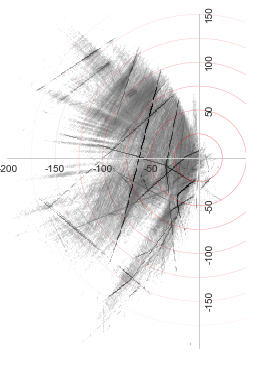

In [351]:
theta = -data['heading'] + 3*np.pi/4.
data['x'] = data['distance'] * np.cos(theta)
data['y'] = data['distance'] * np.sin(theta)

pylab.figure(figsize=(6,6))
ax = setup_polar()
density(data['x'], data['y'], 
        extent=[-200,50,-200,150], label='Log num aircraft', nbins=300, ax=ax,
        logvrange=True, colorbar=False, cmap=pylab.cm.Greys)
ax.set_aspect('equal')
ax.grid('off', axis='y')

# Clean Data

  * There are a bunch of very odd records. Some of these are due to being able to "observe" planes at to the airport so that their GPS signal is quite bad.

(1860239, 16)


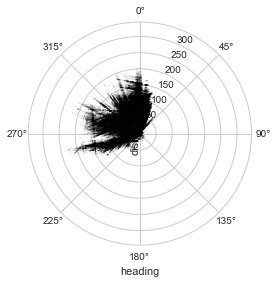

In [373]:
clean =  data[ # Distant Points are are inaccurate
               (data['distance'] < 250) &
               # Look at just two weeks
               (data['datenum'] < 14) &
               # Odd string of points on the left
                ~( (data['heading_deg'] < 240)  &
                   (data['heading_deg'] > 180)  &
                   (data['distance'] > 150)  )
            ]
color = clean['datenum']/clean['datenum'].max()
clean.plot('heading', 'distance', 'scatter', 
         c=color, ax=setup_polarplot(),
         s=1, edgecolor='none', alpha=0.1)
print clean.shape

<matplotlib.colorbar.Colorbar instance at 0x20d2174d0>

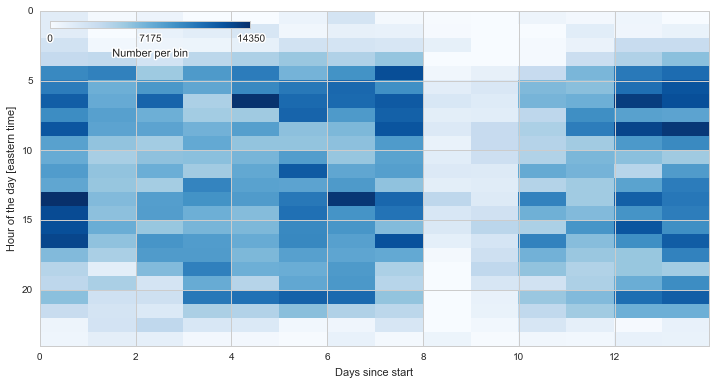

In [313]:
pylab.figure(figsize=(12,6))
pylab.xlabel('Days since start')
pylab.ylabel('Hour of the day [eastern time]')
pylab.ylim(24,0)
den = density(clean['datenum'], clean['hour'], 
              nbins=[14,24], label='Number per bin',
              cmap=pylab.cm.Blues, colorbar=False, )
icolorbar(den)

Number Before: 317,198. Number during:67,827. Number after: 358,680


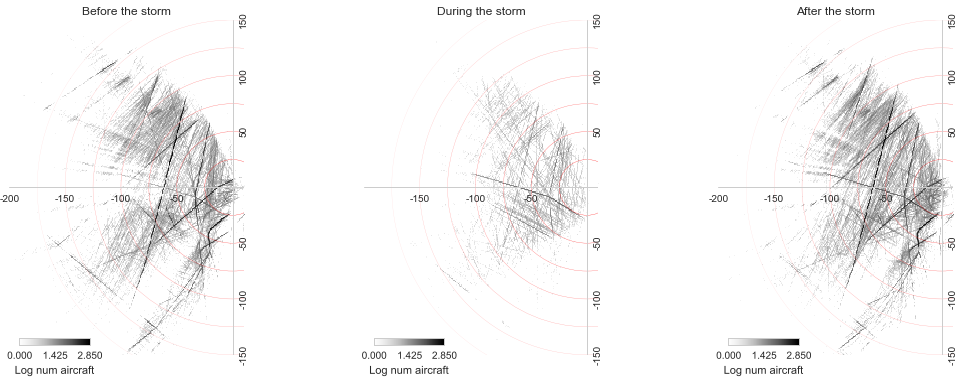

In [375]:
def plot_density(cat, ax):
    den = density(cat['x'], cat['y'],
                  extent=[-200,10,-150,150], label='Log num aircraft', nbins=300, ax=ax,
                  vmin=0, vmax=2.85,
                  logvrange=True, colorbar=False, cmap=pylab.cm.Greys)
    icolorbar(den, loc=3)
    ax.set_aspect('equal')
    ax.grid('off', axis='y')
    return den

    

pylab.figure(figsize=(18,6))

# Before the storm
before = clean[(clean['datenum']>4) & (clean['datenum']<6)]
plot_density(before, ax=setup_polar(131))
pylab.title('Before the storm')


# During the storm
during = clean[(clean['datenum']>8) & (clean['datenum']<10)]
plot_density(during, ax=setup_polar(132))
pylab.title('During the storm')

# After the storm
after = clean[(clean['datenum']>12) & (clean['datenum']<14)]
plot_density(after, ax=setup_polar(133))
pylab.title('After the storm')

print('Number Before: {:,d}. Number during:{:,d}. Number after: {:,d}'
      .format(len(before), len(during), len(after)))

# Prediction time

* Lets try some machine learning algorithms to predict the future. 
* (1) Predict plane identifier using location and hour: Use the before-storm data to train a model to predict the after-storm planes.
* (2) Determine which planes are landing at BWI by which are canceled

In [387]:
clean_tags = ['flight', 'date', 'time', 'weekday', 'normtime', 'datenum', 
              'alt', 'distance', 'heading', 'heading_deg', 'x', 'y']
input_tags = ['lat', 'lon', 'hour']
before_simple = before.drop(clean_tags, axis=1)
before_simple

,lat,lon,hour,flightnum
553149,40.67775,-76.71033,0.981375,164
553150,40.67775,-76.71027,0.981491,164
...,...,...,...,...
870380,39.49017,-78.96441,23.999616,1674
870381,39.76575,-77.91170,23.999663,173


In [386]:
from sklearn import cross_validation
from sklearn.ensemble import RandomForestClassifier

In [ ]:
scores = cross_validation.cross_val_score(
    RandomForestClassifier(
        random_state=0,
        n_estimators=150,
        min_samples_split=4,
        min_samples_leaf=2
    ),
    before_simple[input_tags],
    before_simple['flightnum'],
    cv=3
)

print('{:0.1f}'.format(100*scores.mean()))

# Save Data

In [ ]:
# save it as a db for other things.
# db = dataset.connect('sqlite:///Users/ajmendez/flight.db')
engine = create_engine('sqlite:////Users/ajmendez/flight.db')
if not database_exists(engine.url):
    create_database(engine.url)

with engine.connect() as conn, conn.begin():
    data.to_sql('data', engine)
